In [1]:
import os, sys
sys.path.insert(0, '..')

In [2]:
import gensim
import gc
from os.path import join as j
import json
from tqdm import tqdm, trange
from models import glove, custom_trained_model, word2vec
from utils.dataset import PandasDataset
from utils.weat import WEAT
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


gc.enable()

In [3]:
DIR = '/tmp/temp/'
YEARS = range(1921, 2021, 10)
EMBEDDINGS_DIR = 'embeddings_{}'
MAN, WOMAN, OCCUPATIONS = 'Man words', 'Woman words', 'Occupations with Human Stereotype Scores'
words = json.load(open('../weat/GargWordList.json'))
words[WOMAN].remove('femen') # not sure what femen is !! 
CSV = "df_{st}_to_{end}.csv"
SCORES = np.zeros(shape=(len(YEARS), 7))
CUSTOM_MODEL_PATH = "../trained_models/GoogleNews-vectors-negative300.bin"

In [4]:
def get_bar_plot(y, pred):
    u = np.unique(y)
    classes = len(u)
    match = [0] * classes * 2
    for idx, true in enumerate(y):
        if true == pred[idx]:
            match[true] += 1
        else:
            match[true + classes] += 1
    return pd.DataFrame({'x': list(u) * 2, 'y': match, 'hue': [True] * classes + [False] * classes})

In [5]:
def plot_(x, y, colors, z=None, title="year", three=False, scale=True):
    # https://stackoverflow.com/a/60621783
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig = plt.figure(figsize=(6,6))
    if three:
        ax = Axes3D(fig)
        g = ax.scatter(x, y, z, c=colors, marker='o', depthshade=False, cmap='Paired')
        if scale:
            ax.set_zlim(-1, 1)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
        ax.set_zlabel('Z Label')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_title(title)
        legend = ax.legend(*g.legend_elements(), loc="lower center", borderaxespad=-10, ncol=4)
        ax.add_artist(legend)
    else:
#         print(colors)
        for C in colors:
            mn, mx = colors[C]
            plt.scatter(x[mn:mx], y[mn:mx], c=C)
#         for X, Y, C in zip(x, y, colors): plt.scatter(X, Y, c=C)
        if scale:
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            
        plt.legend(['male', 'female', 'occupation'])
        plt.title(title)
    plt.show()

In [6]:
def plot_model(model, model_title, man_words, woman_words, occupations=[]):
    
    vecs = model.transform(man_words + woman_words + occupations)
    colors = ['blue'] * len(man_words) + ['pink'] * len(woman_words) + ['green'] * len(occupations)
    
    # plot 3D graph using PCA
    three = PCA(random_state=0).fit_transform(vecs)[:, :3]
    plot_(three[:, 0], three[:, 1], z=three[:, 2], title=model_title + "_3D_PCA", three=True, scale=False, colors=colors)
    
    colors = {
        "blue": (0, len(man_words)), 
        "pink": (len(man_words), len(man_words) + len(woman_words)), 
        "green": (len(man_words) + len(woman_words), len(man_words) + len(woman_words) + len(occupations))
    }
    
    # plot 2 D plot using PCA
    two = PCA(random_state=0).fit_transform(vecs)[:, :2]
    plot_(two[:, 0], two[:, 1], title=model_title + "_2D_PCA", three=False, scale=False, colors=colors)
    
    
    # plot LDA
    y = np.concatenate([np.zeros(shape=len(man_words), dtype=int), np.ones(dtype=int, shape=len(woman_words)), 
                    np.full(dtype=int, shape=len(occupations), fill_value=2)]) 
    two = LinearDiscriminantAnalysis().fit_transform(vecs, y)
    
#     knn = KNeighborsClassifier(n_neighbors=3)
#     knn.fit(vecs, y)
#     pred = knn.predict(vecs)
#     df = get_bar_plot(y=y, pred=pred)
    if len(occupations):
        plot_(two[:, 0], two[:, 1], title=model_title + "_2D_LDA", three=False, scale=False, colors=colors)
    else:
        plot_(two[:, 0], y, title=model_title + "_1D_LDA", three=False, scale=False, colors=colors)
#     sns.barplot(data=df, x='x', y='y', hue='hue', ).set_title(model_title + "_KNN classification")
#     plt.show()
    return WEAT(model, words_json='../weat/weat.json').get_scores()

# PRETRAINED MODEL (GOOGLE NEWS)

In [7]:
m = custom_trained_model.CustomTrainedModel(path=CUSTOM_MODEL_PATH, load_params={"binary": True}, load_method=gensim.models.KeyedVectors.load_word2vec_format)

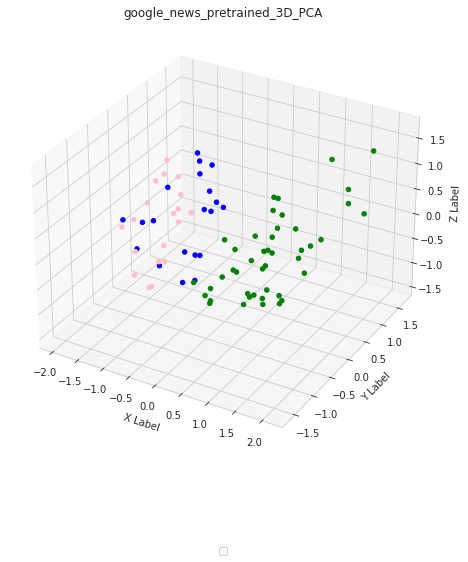

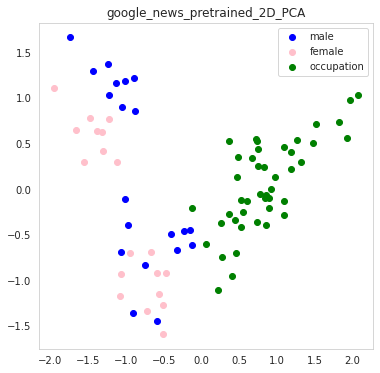

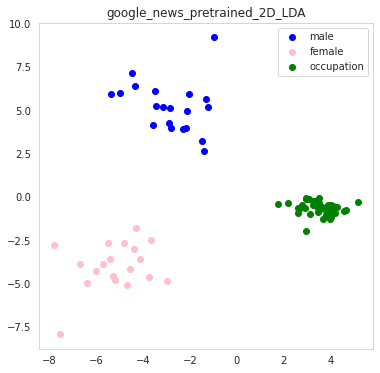

Not found:  4
Not found:  41
Not found:  1
Not found:  12
Not found:  1


[0.07072168467787704,
 0.03995114119298206,
 1.528112,
 1.5191026,
 0.93230057,
 1.6107198899872672,
 1.1951628]

In [8]:
plot_model(model=m, model_title="google_news_pretrained", man_words=words[MAN], woman_words=words[WOMAN], occupations=words[OCCUPATIONS])

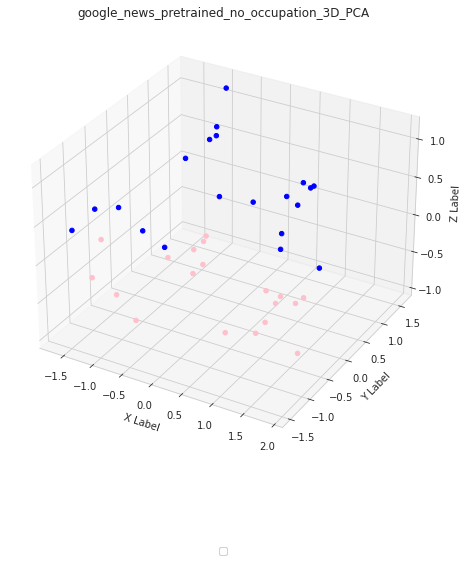

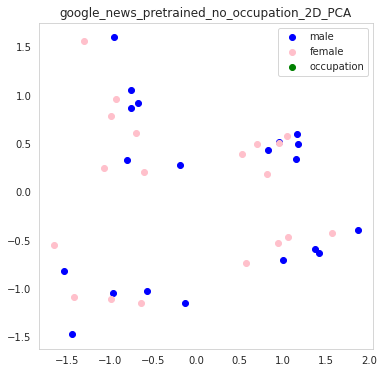

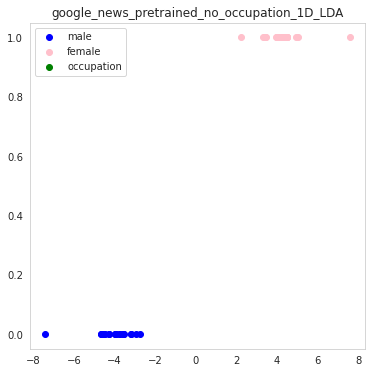

Not found:  4
Not found:  41
Not found:  1
Not found:  12
Not found:  1


[0.07072168467787704,
 0.03995114119298206,
 1.528112,
 1.5191026,
 0.93230057,
 1.6107198899872672,
 1.1951628]

In [9]:
plot_model(model=m, model_title="google_news_pretrained_no_occupation", man_words=words[MAN], woman_words=words[WOMAN])

# PRETRAINED MODEL (Glove)

In [10]:
m = glove.Glove(load=True, path='../trained_models/glove/embeddings_2011/')

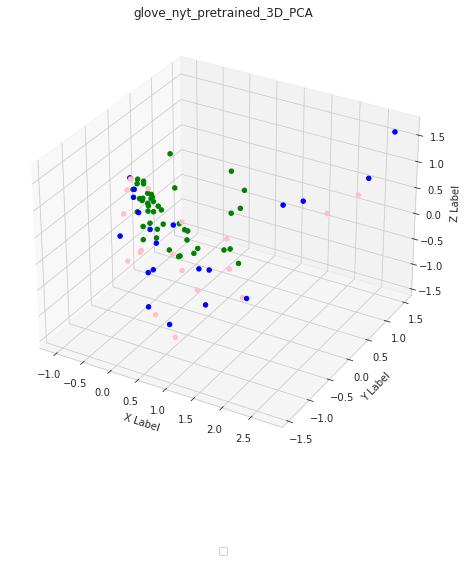

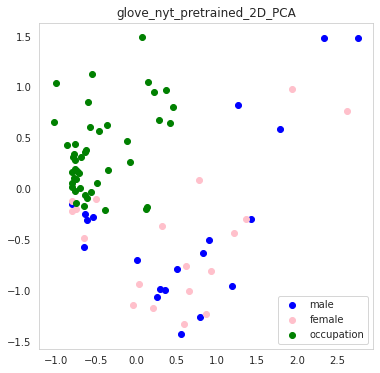

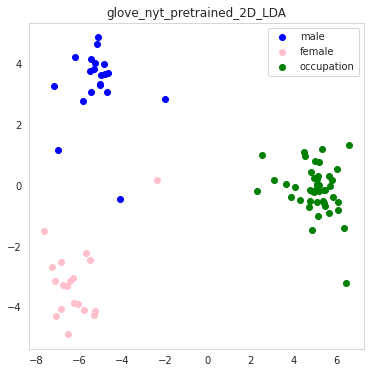

[0.7908381, 0.8409174, 0.3489179, 1.3640121, 1.0904961, 0.7611027, 0.26068294]

In [11]:
plot_model(model=m, model_title="glove_nyt_pretrained", man_words=words[MAN], woman_words=words[WOMAN], occupations=words[OCCUPATIONS])

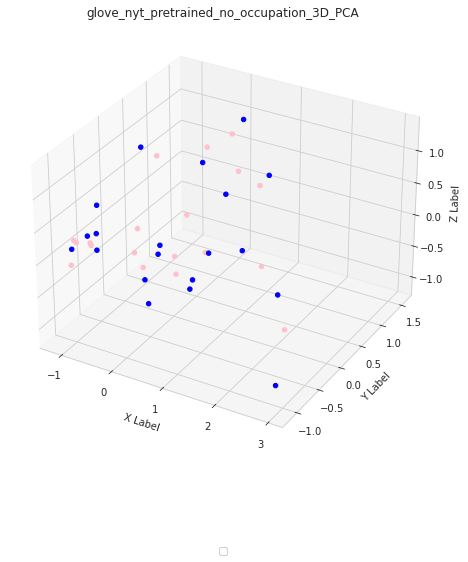

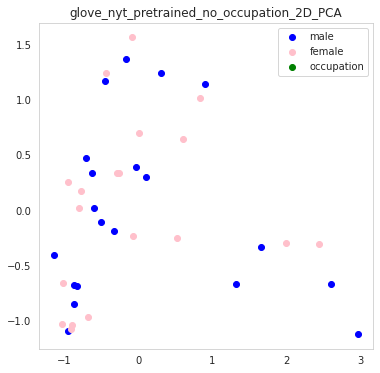

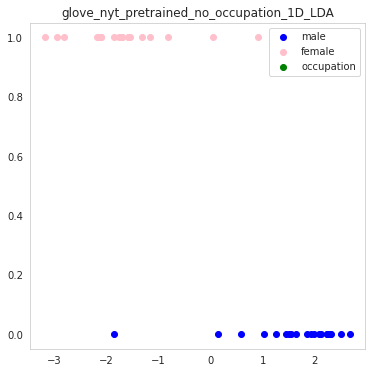

[0.7908381, 0.8409174, 0.3489179, 1.3640121, 1.0904961, 0.7611027, 0.26068294]

In [12]:
plot_model(model=m, model_title="glove_nyt_pretrained_no_occupation", man_words=words[MAN], woman_words=words[WOMAN])

# PRETRAINED MODEL (Word2vec)

In [13]:
m = word2vec.Word2Vec(load=True, path='../trained_models/word2vec/embeddings_2011/')

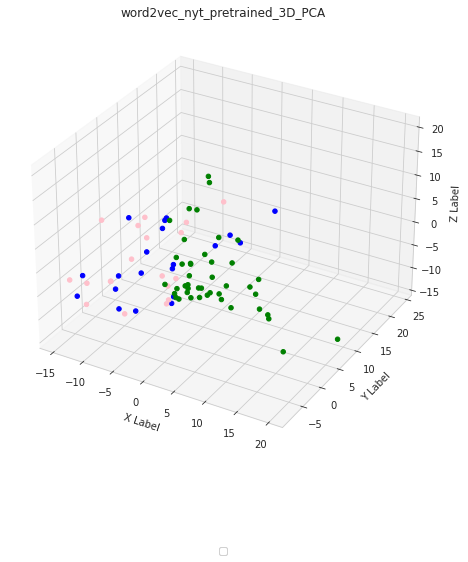

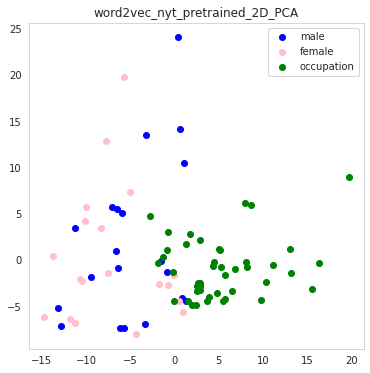

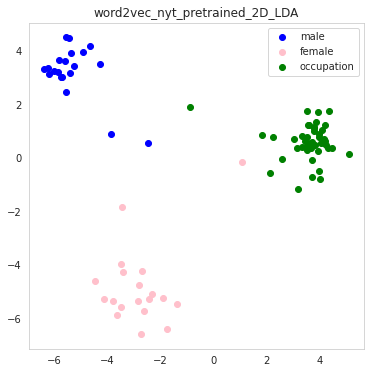

[0.6471209, 0.9870802, 0.3855855, 1.5900886, 1.2569466, 1.0990993, 1.146078]

In [14]:
plot_model(model=m, model_title="word2vec_nyt_pretrained", man_words=words[MAN], woman_words=words[WOMAN], occupations=words[OCCUPATIONS])

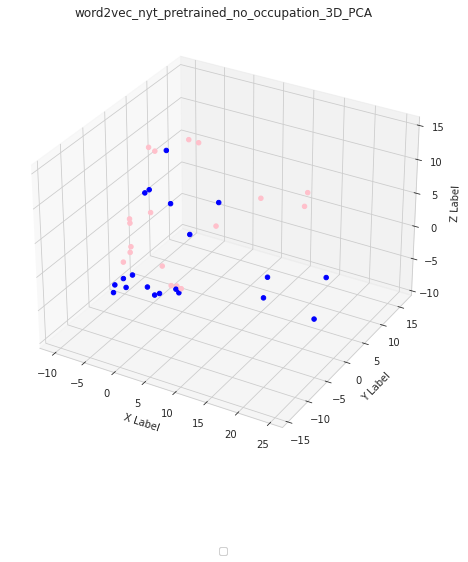

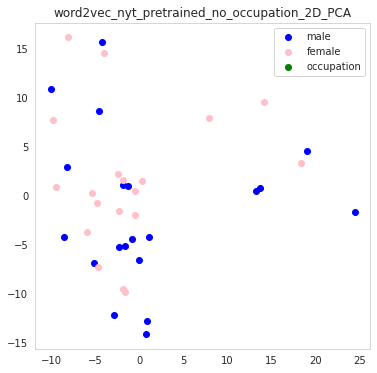

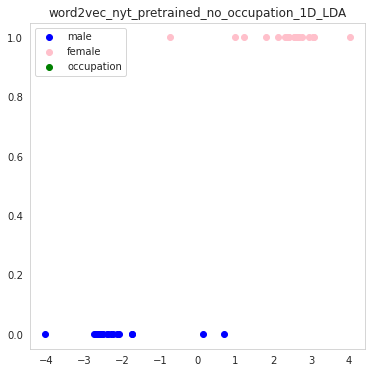

[0.6471209, 0.9870802, 0.3855855, 1.5900886, 1.2569466, 1.0990993, 1.146078]

In [15]:
plot_model(model=m, model_title="word2vec_nyt_pretrained_no_occupation", man_words=words[MAN], woman_words=words[WOMAN])

# Progression of bias using Glove

In [16]:
# Progression of bias using Glove
YEARS = range(1921, 2021, 10)
EMBEDDINGS_DIR = '../trained_models/glove/embeddings_{}/'
MAN, WOMAN, OCCUPATIONS = 'Man words', 'Woman words', 'Occupations with Human Stereotype Scores'
words = json.load(open('../weat/GargWordList.json'))
words[WOMAN].remove('femen') # not sure what femen is !! 
CSV = "df_{st}_to_{end}.csv"
SCORES = np.zeros(shape=(len(YEARS), 7))
CUSTOM_MODEL_PATH = "../trained_models/GoogleNews-vectors-negative300.bin"

In [17]:
years_to_score = {}
for y in YEARS:
    model = glove.Glove(load=True, path=EMBEDDINGS_DIR.format(y))
    years_to_score[y] =  np.mean(np.abs(WEAT(model, words_json='../weat/weat.json').get_scores()))
years_to_score    

{1921: 0.5080289,
 1931: 0.58373225,
 1941: 0.77536196,
 1951: 0.73446685,
 1961: 0.7649283,
 1971: 0.8785966,
 1981: 0.81786144,
 1991: 0.8036569,
 2001: 1.0130584,
 2011: 0.77956676}

[Text(0.5, 1.0, 'Evolution of Gender Bias in NYT (Glove)'),
 Text(0.5, 0, 'year'),
 Text(0, 0.5, 'bias')]

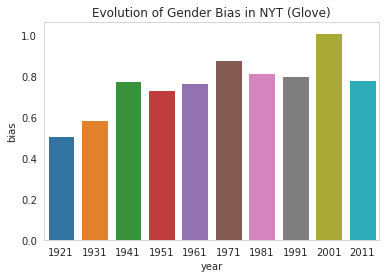

In [18]:
ax = sns.barplot(x=list(years_to_score.keys()), y=list(years_to_score.values()))
ax.set(title="Evolution of Gender Bias in NYT (Glove)", xlabel='year', ylabel='bias')

# Progression of bias using WORD2Vec

In [19]:
years_to_score = {}

EMBEDDINGS_DIR = '../trained_models/word2vec/embeddings_{}/'
for y in YEARS:
    model = word2vec.Word2Vec(load=True, path=EMBEDDINGS_DIR.format(y))
    years_to_score[y] =  np.mean(np.abs(WEAT(model, words_json='../weat/weat.json').get_scores()))
years_to_score    

{1921: 0.9952785,
 1931: 1.0038439,
 1941: 1.0703815,
 1951: 1.0651162,
 1961: 0.9412498,
 1971: 1.0924149,
 1981: 1.0833946,
 1991: 1.0903991,
 2001: 1.3423941,
 2011: 1.0159999}

[Text(0.5, 1.0, 'Evolution of Gender Bias in NYT (Word2Vec)'),
 Text(0.5, 0, 'year'),
 Text(0, 0.5, 'bias')]

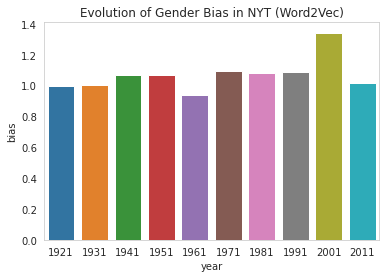

In [20]:
ax = sns.barplot(x=list(years_to_score.keys()), y=list(years_to_score.values()))
ax.set(title="Evolution of Gender Bias in NYT (Word2Vec)", xlabel='year', ylabel='bias')